In [2]:
from salishsea_tools import viz_tools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cmocean.cm as cm
import matplotlib.patches as patches


In [3]:
riv_df = pd.read_csv('../../../../../../results/forcing/rivers/observations/Squamish_Brackendale_flow',header=None,delimiter=' ')
mapping = {riv_df.columns[0]: 'YYYY', riv_df.columns[1]: 'MM', riv_df.columns[2]: 'DD', riv_df.columns[3]: 'DISCHARGE'}
river = riv_df.rename(columns=mapping)

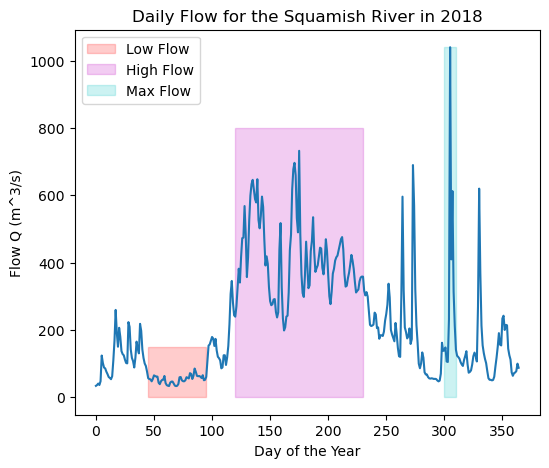

In [4]:
river_2018 = river[river['YYYY'] == 2018]

low_flow = patches.Rectangle((45, 0), 50, 150, linewidth=1, edgecolor='r', facecolor='r',alpha=0.2,label='Low Flow')
high_flow = patches.Rectangle((120, 0), 110, 800, linewidth=1, edgecolor='m', facecolor='m',alpha=0.2,label='High Flow')
max_flow = patches.Rectangle((300, 0), 10, river_2018['DISCHARGE'].max(), linewidth=1, edgecolor='c', facecolor='c',alpha=0.2,label='Max Flow')

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.plot(np.arange(len(river_2018)), river_2018['DISCHARGE'])
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Flow Q (m^3/s)')
ax.set_title('Daily Flow for the Squamish River in 2018')

ax.add_patch(low_flow)
ax.add_patch(high_flow)
ax.add_patch(max_flow)

ax.legend()

In [5]:
# make a mask of land where land is true and water in NaN
bathymetry = xr.open_dataset('../../../../MEOPAR/grid/bathymetry_201702.nc')
land = np.array(np.isnan(bathymetry.Bathymetry).to_numpy(), dtype='float')
land[land == 0] = np.nan

# open the mesh mask and use it to mask the land
mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask201702.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

# just look at my study area
tmask_howe = tmask[:, 500:540, 355:395]

In [13]:
physics = xr.open_dataset('../../../../civil541/HoweSound_dayavg_phys_20180101_20181231.nc')

## Changes go below here

In [26]:
phys_sal = np.mean(physics.vosaline[45:95, :, :, :], axis=0)
phys_temp = np.mean(physics.votemper[45:95, :, :, :], axis=0)

Text(0, 0.5, 'grid Y')

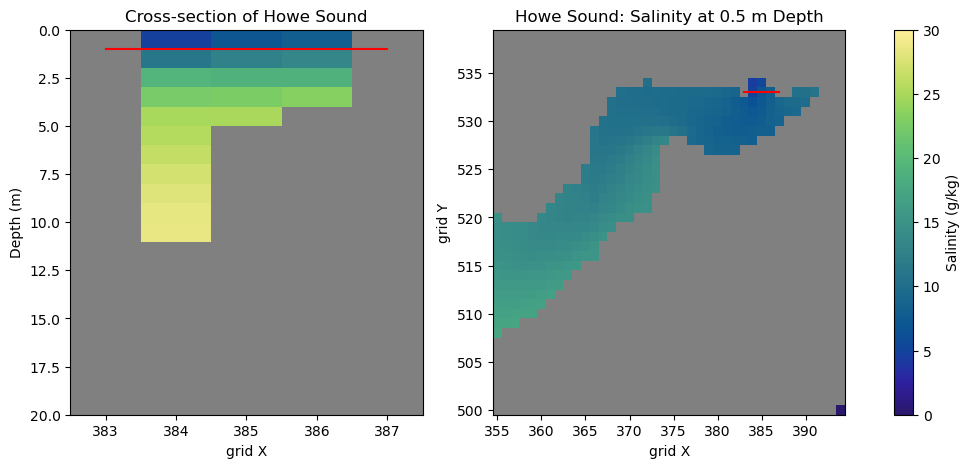

In [25]:
xmin = 28
xmax = 32
yval = 33
max_depth = 20
depth_div = 1
depth_show = 0

cmap = cm.haline
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 2, figsize=(12.5, 5))
salinity = np.ma.masked_array(phys_sal[:, yval, xmin:xmax+1], mask=tmask_howe[:, yval, xmin:xmax+1])
colours = ax[0].pcolormesh(physics.gridX[xmin:xmax+1], physics.depth, salinity, cmap=cmap,vmin=0,vmax=30)
ax[0].set_ylim(0, max_depth)
ax[0].invert_yaxis();
cb = fig.colorbar(colours, ax=ax)
cb.set_label('Salinity (g/kg)');
ax[0].set_title('Cross-section of Howe Sound')
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('grid X')
ax[0].plot(np.arange(xmin, xmax+1)+355, np.zeros(len(np.arange(xmin, xmax+1)))+depth_div, 'r')


salinity = np.ma.masked_array(phys_sal[depth_show], mask=tmask_howe[depth_div])
colours = ax[1].pcolormesh(physics.gridX[0:40+1], physics.gridY[0:40+1], salinity, cmap=cmap,vmin=0,vmax=30)
ax[1].plot(np.arange(xmin, xmax+1)+355, np.zeros(len(np.arange(xmin, xmax+1)))+yval+500,'r')
ax[1].set_title('Howe Sound: Salinity at {} m Depth'.format(str(np.round(physics.depth[depth_show].values,2))))
ax[1].set_xlabel('grid X')
ax[1].set_ylabel('grid Y')

Text(0, 0.5, 'grid Y')

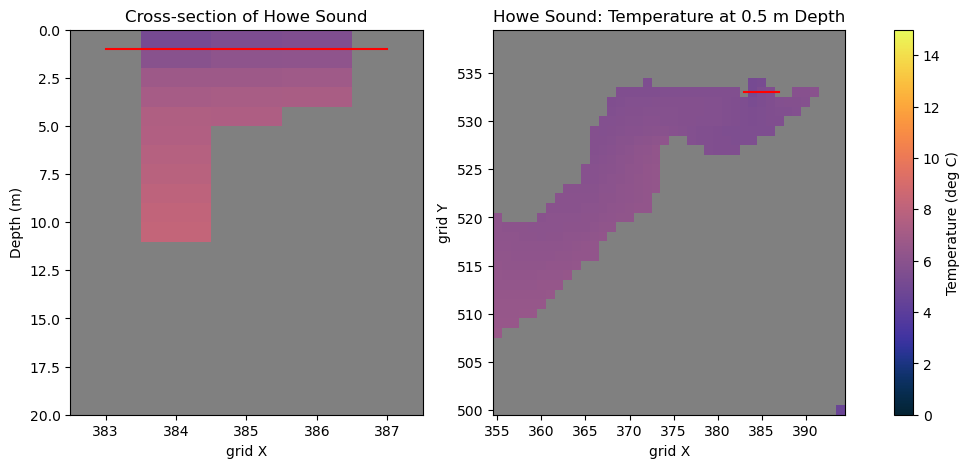

In [28]:
cmap = cm.thermal
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 2, figsize=(12.5, 5))
temper = np.ma.masked_array(phys_temp[:, yval, xmin:xmax+1], mask=tmask_howe[:, yval, xmin:xmax+1])
colours = ax[0].pcolormesh(physics.gridX[xmin:xmax+1], physics.depth, temper, cmap=cmap,vmin=0,vmax=15)
ax[0].set_ylim(0, max_depth)
ax[0].invert_yaxis();
cb = fig.colorbar(colours, ax=ax)
cb.set_label('Temperature (deg C)');
ax[0].set_title('Cross-section of Howe Sound')
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('grid X')
ax[0].plot(np.arange(xmin, xmax+1)+355, np.zeros(len(np.arange(xmin, xmax+1)))+depth_div, 'r')


temper = np.ma.masked_array(phys_temp[depth_show], mask=tmask_howe[depth_div])
colours = ax[1].pcolormesh(physics.gridX[0:40+1], physics.gridY[0:40+1], temper, cmap=cmap,vmin=0,vmax=15)
ax[1].plot(np.arange(xmin, xmax+1)+355, np.zeros(len(np.arange(xmin, xmax+1)))+yval+500,'r')
ax[1].set_title('Howe Sound: Temperature at {} m Depth'.format(str(np.round(physics.depth[depth_show].values,2))))
ax[1].set_xlabel('grid X')
ax[1].set_ylabel('grid Y')

In [29]:
top_slice_sal = physics.vosaline[day, :, yval, xmin:xmax+1][0:depth_div, :]
bot_slice_sal = physics.vosaline[day, :, yval, xmin:xmax+1][depth_div:40, :]

top_slice_temp = physics.votemper[day, :, yval, xmin:xmax+1][0:depth_div, :]
bot_slice_temp = physics.votemper[day, :, yval, xmin:xmax+1][depth_div:40, :]

In [30]:
def avg_layer_phys(top_slice,bot_slice,depth_div):
    sel_water = tmask_howe[:, yval, xmin:xmax+1][0:depth_div, :].to_numpy().flatten() == 0
    top_layer = top_slice.to_numpy().flatten()[sel_water]
    p_top = np.mean(top_layer)

    sel_water = tmask_howe[:, yval, xmin:xmax+1][depth_div:40, :].to_numpy().flatten() == 0
    bot_layer = bot_slice.to_numpy().flatten()[sel_water]
    p_bot = np.mean(bot_layer)

    return list([p_top, p_bot])

In [31]:
S_top, S_bot = avg_layer_phys(top_slice_sal, bot_slice_sal, depth_div)
T_top, T_bot = avg_layer_phys(top_slice_temp, bot_slice_temp, depth_div)

In [40]:
print('S_top = {} g/kg, T_top = {} deg C'.format(str(round(S_top, 2)), str(round(T_top, 2))))
print('S_bot = {} g/kg, T_bot = {} deg C'.format(str(round(S_bot, 2)), str(round(T_bot, 2))))

S_top = 10.59 g/kg, T_top = 4.74 deg C
S_bot = 27.7 g/kg, T_bot = 8.43 deg C
